https://github.com/MaayanLab/Drugmonizome-ML

In [2]:
! pip install umap-learn rdkit-pypi itables

In [3]:
%matplotlib inline
# Imports
## Data processing
import pandas as pd
import numpy as np
import scipy as sp
## Machine Learning
import sklearn as sk
from sklearn import (
    calibration,
    decomposition,
    ensemble,
    feature_selection,
    linear_model,
    manifold,
    metrics,
    model_selection,
    multioutput,
    pipeline,
    preprocessing,
    svm,
    tree,
    feature_extraction,
    neural_network,
)
from split import StratifiedGroupKFold, RepeatedStratifiedGroupKFold
import umap
## Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
## Drugmonizome API
from drugmonizome import Drugmonizome
## SEP-L1000 data retrieval
from sepl1000 import SEPL1000
## L1000FWD queries
import querysepl1000fwd
## Match drug name inputs using PubChem API
from DrugNameConverter import DrugNameConverter
# Utility
import os
import re
import json
from functools import reduce
from IPython.display import display, HTML
from tqdm import tqdm
# Interactive tables
from itables import show
# Plotly fix
import plotly.io as pio
pio.renderers.default = 'notebook'

In [4]:
rng = 2020
np.random.seed(rng)

In [5]:
# Notebook display util functions (adapted from Nicole Moiseyev's Patient Cohorts RNA-Seq Viewer appyter)

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

table_number = 0
figure_number = 0
def figure_header(label,title):
    global table_number
    global figure_number
    if label == 'Table':
        table_number += 1
        label = f'Table {table_number}'
    elif label == 'Figure':
        figure_number += 1
        label = f'Figure {figure_number}'
    display(HTML(f"<div style='font-size:1.5rem; padding:1rem 0;'><b>{label}</b>: {title}</div>"))
    
def figure_legend(label,title,content=''):
    global table_number
    global figure_number
    if label == 'Table':
        label = f'Table {table_number}'
    elif label == 'Figure':
        label = f'Figure {figure_number}'
    display(HTML(f'<style>div.caption {{text-align: center;}}</style><div class=caption><b>{label}</b>: <i>{title}</i>. {content} </div>'))

## Select Input Datasets and Target Classes

Selected drug set libraries and phenotypic datasets are downloaded and joined on the compound InChI Key to produce a large input feature matrix. A machine learning model will be trained to predict the specified target labels from these features. This is a binary classification task that can be used to predict compounds that are likely to be associated with the target class.

To construct the input matrix, we download drug set libraries and phenotypic datasets and join them on the InChI Key.
 We can either include drugs that are present in all datasets or include those that don't appear in all datasets, yet still have a reasonable count/presence throughout. 


In [6]:
# Use the selected SEP-L1000 datasets
sepl1000_phenotypic_datasets = ['LINCS Gene Expression Signatures', 'GO Transformed Signatures (PAEA)']
# , 'MLPCN Cell Morphological Profiling']
sepl1000_structural_datasets = ['MACCS Chemical Fingerprint', 'Morgan Chemical Fingerprint']
dataset_sizes = []

In [7]:
phenotypic_datasets = {
    'LINCS Gene Expression Signatures': 'LINCS_Gene_Experssion_signatures_CD.csv.gz',
    'GO Transformed Signatures (PAEA)': 'GO_transformed_signatures_PAEA.csv.gz'
    # ,
    # 'MLPCN Cell Morphological Profiling': 'MLPCN_morplological_profiles.csv.gz'
}
df_sepl1000_phenotypic = list(SEPL1000.download_df(list(phenotypic_datasets[dataset] for dataset in sepl1000_phenotypic_datasets),
                                             index_col=0))
dataset_sizes += list(zip(sepl1000_phenotypic_datasets, [dataset.shape[1] for dataset in df_sepl1000_phenotypic]))
# Assemble all phenotypic SEP-L1000 datasets
if len(df_sepl1000_phenotypic) > 1:
    # Obtain merged dataframe with omics and target data
    df_sepl1000 = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='inner', # Keep only matched indices
        ),
        df_sepl1000_phenotypic,
    )
else:
    df_sepl1000 = df_sepl1000_phenotypic[0]
# Mean-fill infinite and missing values
df_sepl1000 = df_sepl1000.replace([np.inf, -np.inf], np.nan)
df_sepl1000 = df_sepl1000.fillna(np.mean(df_sepl1000))

In [64]:
df_sepl1000.shape

(20379, 5416)

In [8]:
# Structural dataset processing
structural_datasets = {
    'MACCS Chemical Fingerprint': 'MACCS_bitmatrix.csv.gz',
    'Morgan Chemical Fingerprint': 'Morgan_bitmatrix.csv.gz',
}
df_sepl1000_structural = list(SEPL1000.download_df(list(structural_datasets[dataset] for dataset in sepl1000_structural_datasets),
                                             index_col=0))
dataset_sizes += list(zip(sepl1000_structural_datasets, [dataset.shape[1] for dataset in df_sepl1000_structural]))
# Assemble all structural SEP-L1000 datasets
if len(df_sepl1000_structural) > 1:
    # Obtain merged dataframe with omics and target data
    df_sepl1000_fingerprints = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='inner', # Keep only matched indices
        ),
        df_sepl1000_structural,
    )
else:
    df_sepl1000_fingerprints = df_sepl1000_structural[0]
# Apply tf-idf normalization
transformer = feature_extraction.text.TfidfTransformer()
X_tfidf = transformer.fit_transform(df_sepl1000_fingerprints).toarray()
df_sepl1000_fingerprints = pd.DataFrame(X_tfidf, columns=df_sepl1000_fingerprints.columns, index=df_sepl1000_fingerprints.index)
# Concatenate structural features with phenotypic features
#df_sepl1000 = pd.merge(df_sepl1000, df_sepl1000_fingerprints, left_index=True, right_index=True) # Keep only matched indices

In [9]:
df_sepl1000.columns

Index(['PSME1', 'ATF1', 'RHEB', 'FOXO3', 'RHOA', 'IL1B', 'ASAH1', 'RALA',
       'ARHGEF12', 'SOX2',
       ...
       'transcription corepressor activity (GO:0003714)',
       'mRNA processing (GO:0006397)',
       'regulation of cell proliferation involved in heart morphogenesis (GO:2000136)',
       'transport vesicle membrane (GO:0030658)',
       'intra-S DNA damage checkpoint (GO:0031573)',
       'negative regulation of smooth muscle contraction (GO:0045986)',
       'response to molecule of bacterial origin (GO:0002237)',
       'HOPS complex (GO:0030897)',
       'positive regulation of megakaryocyte differentiation (GO:0045654)',
       'negative regulation of sister chromatid segregation (GO:0033046)'],
      dtype='object', length=5416)

In [62]:
# Use the selected attribute datasets
attribute_datasets = [
                      # 'L1000FWD Downregulated Signatures', 'L1000FWD Upregulated Signatures', 
                      # 'L1000FWD Downregulated GO Biological Processes', 'L1000FWD Upregulated GO Biological Process', 
                      # 'L1000FWD Downregulated GO Cellular Components', 'L1000FWD Upregulated GO Cellular Components', 
                      # 'L1000FWD Downregulated GO Molecular Function', 'L1000FWD Upregulated GO Molecular Function', 
                      # 'L1000FWD Downregulated KEGG Pathways', 'L1000FWD Upregulated KEGG Pathways', 'L1000FWD Predicted Side Effects', 
                      # 'DrugCentral Targets', 
                      'DrugRepurposingHub Drug Targets']#, 
                      #'Drugbank Small Molecule Carriers', 'Drugbank Small Molecule Enzymes', 'Drugbank Small Molecule Transporters', 
                      #'Drugbank Small Molecule Targets'] #, 
                      # 'Geneshot Associated Genes', 
                      #'DrugRepurposingHub Mechanisms of Action']
                      # , 'PharmGKB OFFSIDES Side Effects']
                      # , 'SIDER Indications', 'SIDER Side Effects']
df_attributes = list(Drugmonizome.download_df(
    [dataset
     for dataset in attribute_datasets]
))
dataset_sizes += list(zip(attribute_datasets, [dataset.shape[1] for dataset in df_attributes]))
# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='inner', # Keep only matched indices
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]
del(df_attributes)
df = df.fillna(0)
X = df.applymap(lambda f: 1 if f!=0 else 0)
# Apply tf-idf normalization
transformer = feature_extraction.text.TfidfTransformer()
X_tfidf = transformer.fit_transform(X).toarray()
X = pd.DataFrame(X_tfidf, columns=X.columns, index=X.index)
#X = pd.merge(df_sepl1000, X, left_index=True, right_index=True, how='outer') # Keep only matched indices

In [100]:
X = df_sepl1000
X.shape

(20379, 5416)

In [95]:
# View input data
figure_header('Table', 'Input data')
display(X.head())
figure_legend('Table', 'Input data',
              f'The input data contain {X.shape[0]} compounds and {X.shape[1]} features per compound, \
              taken from the following datasets: {", ".join(sepl1000_phenotypic_datasets + sepl1000_structural_datasets + attribute_datasets)}.')

,PSME1,ATF1,RHEB,FOXO3,RHOA,IL1B,ASAH1,RALA,ARHGEF12,SOX2,SERPINE1,HLA-DMA,EGF,APP,NOS3,CSNK1A1,NFATC4,TBP,BRCA1,PSMD4,ETV1,TERT,EED,PTK2B,HSPB1,PIK3C3,CBLB,DFFB,TGFB3,PRKX,CCND1,NFKBIB,GLI2,PIK3CA,RPS6,DFFA,SUZ12,TICAM1,EDN1,SQSTM1,...,regulation of catenin import into nucleus (GO:0035412),potassium ion transport (GO:0006813),lymphocyte mediated immunity (GO:0002449),smoothened signaling pathway (GO:0007224),negative regulation of endothelial cell proliferation (GO:0001937),positive regulation of steroid biosynthetic process (GO:0010893),poly-pyrimidine tract binding (GO:0008187),negative regulation of calcium ion transmembrane transport (GO:1903170),anterior/posterior pattern specification (GO:0009952),negative regulation of heart rate (GO:0010459),response to glucocorticoid (GO:0051384),icosanoid receptor activity (GO:0004953),xenobiotic metabolic process (GO:0006805),positive regulation of Rab GTPase activity (GO:0032851),purine deoxyribonucleotide metabolic process (GO:0009151),phosphatase complex (GO:1903293),regulation of T-helper cell differentiation (GO:0045622),regulation of stem cell proliferation (GO:0072091),type I transforming growth factor beta receptor binding (GO:0034713),ESCRT complex (GO:0036452),muscle tissue morphogenesis (GO:0060415),establishment of mitotic spindle orientation (GO:0000132),site of polarized growth (GO:0030427),negative regulation of extrinsic apoptotic signaling pathway via death domain receptors (GO:1902042),negative regulation of wound healing (GO:0061045),microbody membrane (GO:0031903),regulation of osteoclast differentiation (GO:0045670),regulation of membrane protein ectodomain proteolysis (GO:0051043),platelet alpha granule (GO:0031091),ribonucleoprotein complex subunit organization (GO:0071826),transcription corepressor activity (GO:0003714),mRNA processing (GO:0006397),regulation of cell proliferation involved in heart morphogenesis (GO:2000136),transport vesicle membrane (GO:0030658),intra-S DNA damage checkpoint (GO:0031573),negative regulation of smooth muscle contraction (GO:0045986),response to molecule of bacterial origin (GO:0002237),HOPS complex (GO:0030897),positive regulation of megakaryocyte differentiation (GO:0045654),negative regulation of sister chromatid segregation (GO:0033046)
InChI Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAALVYBICLMAMA-UHFFFAOYSA-N,0.0476,0.0041,0.0235,0.0047,0.0141,-0.0238,-0.0004,0.0109,-0.0039,-0.0628,0.0012,0.1401,-0.0277,-0.0070,0.0690,-0.0038,-0.0268,-0.0033,-0.0241,-0.0118,-0.0307,0.0207,-0.0174,0.0013,-0.0021,-0.0062,-0.0071,-0.0426,0.0117,0.0415,0.0095,-0.0625,0.0124,0.0145,-0.0082,0.0230,-0.0120,-0.0033,0.0035,0.0054,...,0.9432,0.0465,10.8987,-0.0000,0.1175,0.2915,0.0412,0.4493,1.3370,0.1873,0.5768,1.8962,1.3990,0.0183,0.0784,0.2008,0.6980,3.8862,0.5567,0.6759,1.4170,0.3594,0.2936,3.2882,2.2465,0.5498,6.1147,0.1506,3.7494,0.0411,1.7105,0.0064,4.7721,1.1115,0.1595,0.0562,2.9643,0.0483,0.0210,0.9268
AACFPJSJOWQNBN-UHFFFAOYSA-N,0.0031,0.0136,0.0079,0.0030,0.0126,0.0168,0.0134,0.0152,-0.0275,0.0050,0.0048,-0.0243,0.0052,0.0118,-0.0251,-0.0113,-0.0171,0.0145,-0.0097,0.0006,0.0020,0.0022,0.0042,0.0096,-0.0162,-0.0070,0.0196,0.0203,0.0348,-0.0160,0.0139,-0.0007,0.0200,0.0020,-0.0008,0.0064,0.0010,0.0219,-0.0118,0.0005,...,1.5701,0.4937,0.1843,0.0008,0.3191,0.0276,0.2772,0.3372,0.6237,0.6367,7.8113,1.3166,7.8467,0.0006,0.5892,0.0951,0.6229,0.8900,1.0169,0.0677,1.9150,0.1639,0.1574,0.6996,0.0940,0.0221,0.3584,0.5843,2.3296,0.0095,1.1613,-0.0000,0.4999,0.1392,0.0449,0.8166,12.8236,0.3451,0.1043,0.5171
AADCDMQTJNYOSS-LBPRGKRZSA-N,-0.0170,0.0269,0.0057,0.0316,-0.0064,0.0191,0.0398,-0.0530,0.0191,0.0041,0.0228,-0.0162,-0.0044,0.0043,-0.0275,-0.0194,0.0117,0.0075,-0.0090,0.0043,-0.0048,0.0239,-0.0190,-0.0017,-0.0625,0.0023,-0.0052,-0.0238,-0.0122,0.0109,-0.0198,-0.0181,-0.0087,0.0210,-0.0003,0.0080,0.0253,-0.0014,-0.0203,0.0147,...,1.9696,0.0010,1.8616,0.2925,0.3131,0.0521,0.0369,0.0440,0.3235,-0.0000,1


The target labels are produced from the uploaded list of hits: 1 if the drug is specified as a hit, 0 otherwise.



In [13]:
# # Using user-specified list of positive drug hits
# hits_filename = 'COVID19ScreenHits-InChl.txt'
# def save_items(out_file, items):
#     """
#     Saves list of items as rows in a file.
#     """
#     with open(out_file, 'w') as f:
#         for i in range(len(items)):
#             if i < len(items) - 1:
#                 f.write(items[i] + '\n')
#             else:
#                 f.write(items[i])
# # Read InChI Keys from file
# with open(hits_filename, 'r') as hits_file:
#     drug_hits = set(drug.strip().upper() for drug in hits_file.read().strip().split('\n') 
#                     if len(drug.strip()) > 0)


In [37]:
# Using user-specified list of positive drug hits
hits_filename = 'autophagy_activators.txt'
# Helper functions
def merge(A, B, f):
    """
    Merges two dictionaries, where items from shared keys are merged using a custom function.
    """
    merged = {k: A.get(k, B.get(k)) for k in A.keys() ^ B.keys()}
    merged.update({k: f(A[k], B[k]) for k in A.keys() & B.keys()})
    return merged
def save_items(out_file, items):
    """
    Saves list of items as rows in a file.
    """
    with open(out_file, 'w') as f:
        for i in range(len(items)):
            if i < len(items) - 1:
                f.write(items[i] + '\n')
            else:
                f.write(items[i])
def save_gmt(out_file, keys_to_sets, sep='\t'):
    """
    Saves dict with key-set pairs as gmt file format.
    """
    lines = []
    for key in sorted(keys_to_sets):
        lines.append(key + sep*2 + sep.join(sorted(keys_to_sets[key])))
    save_items(out_file, lines)
# Read drug names from file
with open(hits_filename, 'r') as hits_file:
    drug_hits = set(drug.strip().lower() for drug in hits_file.read().strip().split('\n') 
                    if len(drug.strip()) > 0)
# Query PubChem API to map drug names to InChI Keys
print('Querying PubChem API...')
drug_hits_inchi_pubchem = DrugNameConverter.batch_to_inchi_keys(drug_hits)
# Query Drugmonizome API to map drug names to InChI Keys
print('Querying Drugmonizome API...')
drug_hits_inchi_drugmonizome = Drugmonizome.map_names_to_inchi_keys(drug_hits)
# Query L1000FWD API to map drug names to InChI Keys
print('Querying L1000FWD API...')
drug_hits_inchi_l1000fwd = querysepl1000fwd.map_names_to_inchi_keys(drug_hits)
# Combine InChI Keys from all resources
drug_hits_inchi = merge(drug_hits_inchi_pubchem, drug_hits_inchi_drugmonizome, lambda s1, s2: s1 | s2)
drug_hits_inchi = merge(drug_hits_inchi, drug_hits_inchi_l1000fwd, lambda s1, s2: s1 | s2)
save_gmt('hits_drug_name_to_inchi_keys.gmt', drug_hits_inchi)
# Unmatched drug names
unmatched_drugs = set(drug for drug in drug_hits
                      if drug not in drug_hits_inchi or len(drug_hits_inchi[drug]) == 0)
print(f'Drugs without InChI Keys ({ len(unmatched_drugs) }/{ len(drug_hits) }):', unmatched_drugs)
# Set of InChI Keys for user-specified hits
drug_hits = set(key for drug in drug_hits_inchi
                    for key in drug_hits_inchi[drug])
save_items('hits_inchi_keys.txt', sorted(drug_hits))

Querying PubChem API...


100%|██████████| 94/94 [00:13<00:00,  7.18it/s]


Querying Drugmonizome API...
Querying L1000FWD API...


100%|██████████| 94/94 [00:21<00:00,  4.44it/s]

Drugs without InChI Keys (11/94): {'padk', 'irisin', 'ank-199', 'qw24', 'th2849', 'quercetin sophoretin', 'sd1002', 'mhy218', 'nicotinate-curcumin', 'sar245408 pilaralisib', 'rctrp9'}


In [104]:
df_target = list(Drugmonizome.download_df(
    #['L1000FWD Downregulated Signatures']
    #['Geneshot Associated Genes',
    #  ['L1000FWD Upregulated Signatures']
    #  ['Geneshot Predicted Enrichr Genes']
    ['SIDER Side Effects']
))
df = df_target[0]
df = df.fillna(0)
Y = df.applymap(lambda f: 1 if f!=0 else 0)
# drug_hits = set(Y[Y['TFEB'] == 1].index)
drug_hits = set(Y[Y['neuropathy peripheral'] == 1].index)
# Helper function
def save_items(out_file, items):
    """
    Saves list of items as rows in a file.
    """
    with open(out_file, 'w') as f:
        for i in range(len(items)):
            if i < len(items) - 1:
                f.write(items[i] + '\n')
            else:
                f.write(items[i])
save_items('hits_inchi_keys.txt', sorted(drug_hits))


We produce a target array containing 1 if the compound is specified as a hit and 0 otherwise.


In [105]:
# Match full InChI Keys
y = np.array([drug in drug_hits for drug in X.index]).astype(np.int8)
unmatched = list(set(drug_hits) - set(X.index))
save_items('unmatched_inchikeys.txt', unmatched)
print('Number of hits matched in input: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))
print('Number of unmatched hits: %d' % (len(unmatched)))

Number of hits matched in input: 223 (1.094 %)
Number of unmatched hits: 114


In [106]:
#unmatched

* File of unmatched InChI keys: [unmatched_inchikeys.txt](./unmatched_inchikeys.txt)

In [107]:
# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Input shape: (20379, 5416)
Target shape: (20379,)


## Dimensionality Reduction and Visualization

We reduce the dimensionality of our omics feature space for visualization with UMAP.

In [108]:
clf_dimensionality_reduction = umap.UMAP(low_memory=True, random_state=rng)
#X = X.fillna(0)
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)

In [109]:
X_reduced_df = pd.DataFrame(X_reduced, columns=['Component 1', 'Component 2'])
X_reduced_df['Drug Name'] = querysepl1000fwd.get_drug_names(X.index)
X_reduced_df['InChI Key'] = X.index
X_reduced_df['Label'] = y
X_reduced_df['marker symbol'] = ['x' if label else 'circle' for label in X_reduced_df['Label']]
X_reduced_df['text'] = ['<br>'.join(['Drug Name: ' + str(name),
                                     'InChI Key: ' + str(inchi),
                                     'Label: ' + str(label)])
                        for name, inchi, label in zip(X_reduced_df['Drug Name'],
                                                      X_reduced_df['InChI Key'],
                                                      X_reduced_df['Label'])]

In [110]:
fig = go.Figure()
for label in set(X_reduced_df['Label']):
    X_plot = X_reduced_df[X_reduced_df['Label'] == label].sort_values('Label')
    fig.add_trace(go.Scatter(mode='markers',
                             x=X_plot['Component 1'], y=X_plot['Component 2'],
                             text=X_plot['text'],
                             name=label,
                             marker=dict(
                                 color=['#0d0887', '#f0f921'][label%2],
                                 size=8,
                                 symbol=X_plot['marker symbol'],
                                 line_width=1,
                                 line_color='white'
                             )))
fig.update_layout(height=600, width=800,
                  xaxis_title='Component 1',
                  yaxis_title='Component 2',
                  title_text='Known Labels (UMAP)',
                  #legend_title_text='Target Label',
                  template='simple_white')
figure_header('Figure', 'Input feature space with UMAP dimensionality reduction')
fig.show(renderer='colab')
figure_legend('Figure', 'Input feature space with UMAP dimensionality reduction',
              f'Each point represents one of {X.shape[0]} compounds, with {X.shape[1]} features per compound, \
              taken from the following datasets: {", ".join(sepl1000_phenotypic_datasets + sepl1000_structural_datasets + attribute_datasets)}. \
              Compounds with known positive labels are marked by X\'s.')

Output hidden; open in https://colab.research.google.com to view.

## Machine Learning

We train and evaluate a machine learning model across multiple cross-validation splits by randomly dividing the input dataset into training and validation sets. For each round of cross-validation, a model is trained on the training set and is then used to make predictions for the compounds in the validation set. Each compound appears in at least one validation set, so the validation set predictions are used to assess model performance based on existing labels and to suggest novel predictions.

We apply a sklearn pipeline with a dimensionality reduction step of None
 and a calibrated ExtraTreesClassifier classifier
using 10-fold RepeatedStratifiedGroupKFold cross-validation,
optimizing roc_auc.

Note that training can take a long time as we are training a model for each of multiple cross-validation splits.

In [111]:
cv = RepeatedStratifiedGroupKFold(
    n_splits=10,
    n_repeats=3,
    random_state=rng,
)
groups=[key[:14] for key in X.index]    # Group compounds by atom connectivity
# Scoring parameters
primary_metric = 'roc_auc'
evaluation_metrics = []
scoring_params = {k: metrics.get_scorer(k)
                  for k in [primary_metric, *evaluation_metrics]}

In [ ]:
df_results = pd.DataFrame()
# Store performance on each split for computing ROC and PRC curves
fprs = []
tprs = []
precs = []
recs = []
# Store cross-validation test predictions and folds
y_proba_cv = [[] for _ in range(len(y))]
folds_cv = [[] for _ in range(len(y))]
# Store models
models = []
groups=[key[:14] for key in X.index]    # Group compounds by atom connectivity
for fold, (train, test) in tqdm(enumerate(cv.split(X.values, y, groups=groups))):
    model = sk.pipeline.Pipeline([
                ('clf', sk.ensemble.ExtraTreesClassifier(n_estimators=1250, criterion="entropy", min_samples_split=2, min_samples_leaf=1, max_features="log2", min_impurity_decrease=0.0, n_jobs=-1, class_weight="balanced", ccp_alpha=0.0)
                ),
                  # ('clf', sk.ensemble.GradientBoostingClassifier(loss="deviance", learning_rate=0.1, 
                  #                                              n_estimators=100, subsample=1.0, criterion="friedman_mse", tol=0.0001)
                  # ),    
                  # ('clf', sk.ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_split=2, min_samples_leaf=1, max_features=None, min_impurity_decrease=0.0, n_jobs=-1, class_weight="balanced", ccp_alpha=0.0)
                  # ),
              ])
    model.fit(X.values[train], y[train])
    calibrator = sk.calibration.CalibratedClassifierCV(model, cv='prefit')
    calibrator.fit(X.values[test], y[test])
    model = calibrator
    df_results.loc[fold, 'roc_auc'] = scoring_params['roc_auc'](model, X.values[test], y[test])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    for i in range(len(test)):
        y_proba_cv[test[i]].append(y_proba[i, 1])
        folds_cv[test[i]].append(fold % 10)
    model_fpr, model_tpr, _ = metrics.roc_curve(y[test], y_proba[:, 1])
    model_prec, model_rec, _ = metrics.precision_recall_curve(y[test], y_proba[:, 1])
    fprs.append(model_fpr)
    tprs.append(model_tpr)
    precs.append(model_prec)
    recs.append(model_rec)
    models.append(model)
assert not(any(len(probs) == 0 for probs in y_proba_cv)), 'All probabilities should have been calculated'
display(df_results.agg(['mean', 'std']))

30it [1:28:38, 177.27s/it]


,roc_auc
mean,0.684045
std,0.048681


This visualization shows the cross-validated performance of the model. Low fold variance and high AUC is desired in a well-generalized model.
* ROC curve: [roc.svg](./roc.svg)
* Precision-recall curve: [prc.svg](./prc.svg)
* Confusion matrix: [confusion_matrix.svg](./confusion_matrix.svg)

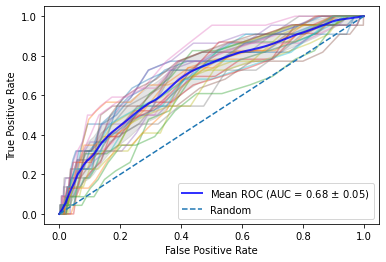

Confidence interval (95%) (0.5902739127323745, 0.7778940176727757)
We are 99.994 % confident the model's results are not just chance.
This is statistically significant. These results can be trusted.


In [ ]:
fig, ax = plt.subplots()
tprs_interp = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for fold, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.
    roc_auc = metrics.auc(fpr, tpr)
    tprs_interp.append(tpr_interp)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4)
mean_tpr = np.mean(tprs_interp, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs_interp, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.plot([0,1],[0,1],'--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.savefig('roc.svg')
figure_header('Figure', 'Receiver operating characteristic (ROC) curves across cross-validation splits ({})'.format(make_clickable('roc.svg')))
plt.show()
figure_legend('Figure', 'Receiver operating characteristic (ROC) curves across cross-validation splits ({})'.format(make_clickable('roc.svg')),
              'Individual curves are shown for each 10-fold cross-validation split, repeated with 3 different randomizations. \
               Mean ROC shows the average and standard deviation across cross-validation splits.')
z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')

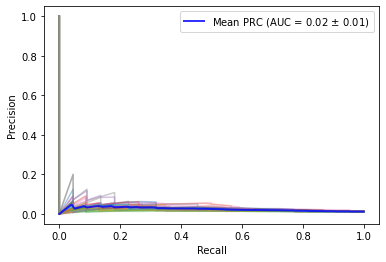

In [ ]:
fig, ax = plt.subplots()
precs_interp = []
prc_aucs = []
mean_rec = np.linspace(0, 1, 100)
for fold, (rec, prec) in enumerate(zip(recs, precs)):
    prec_interp = np.interp(mean_rec, rec[::-1], prec[::-1])
    prc_auc = metrics.auc(rec, prec)
    precs_interp.append(prec_interp)
    prc_aucs.append(prc_auc)
    ax.plot(rec, prec, alpha=0.4)
mean_prec = np.mean(precs_interp, axis=0)
mean_auc = sk.metrics.auc(mean_rec, mean_prec)
std_auc = np.std(prc_aucs)
ax.plot(mean_rec, mean_prec, color='b',
         label=r'Mean PRC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_prec = np.std(precs_interp, axis=0)
precs_upper = np.minimum(mean_prec + std_prec, 1)
precs_lower = np.maximum(mean_prec - std_prec, 0)
plt.fill_between(mean_rec, precs_lower, precs_upper, color='grey', alpha=.2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
plt.savefig('prc.svg')
figure_header('Figure', 'Precision-recall curves (PRC) across cross-validation splits ({})'.format(make_clickable('prc.svg')))
plt.show()
figure_legend('Figure', 'Precision-recall curves (PRC) across cross-validation splits ({})'.format(make_clickable('prc.svg')),
              'Individual curves are shown for each 10-fold cross-validation split, repeated with 3 different randomizations. \
               Mean PRC shows the average and standard deviation across cross-validation splits.')

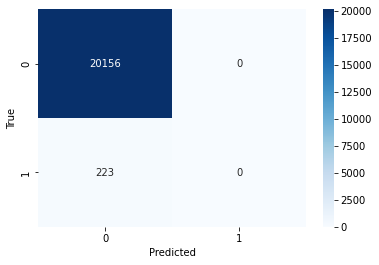

In [ ]:
sns.heatmap(
    metrics.confusion_matrix(y, np.array([np.mean(probs) for probs in y_proba_cv]) > 0.5),
    annot=True,
    cmap=plt.cm.Blues,
    fmt='g'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.svg')
figure_header('Figure', 'Confusion matrix for cross-validation predictions ({})'.format(make_clickable('confusion_matrix.svg')))
plt.show()
figure_legend('Figure', 'Confusion matrix for cross-validation predictions ({})'.format(make_clickable('confusion_matrix.svg')),
              'Note that the predicted probabilities can be greatly affected by imbalanced labels and by the model choice. \
               Thus, performance measures such as ROC and PRC, which evaluate performance across a range of prediction thresholds, \
               are more useful than the confusion-matrix, which uses an fixed cutoff of 0.5')

## Examine predictions

By examining the validation-set predictions, we can rank the positive compounds and identify additional compounds that were not known to be in the positive class, but nevertheless had high predictions. These may share similar properties with the known compounds.

First, we can compare the distribution of predictions for positive and negative labels.

In [ ]:
# Calculate mean and deviation of predictions
y_probas = np.array([np.mean(probs) for probs in y_proba_cv])
y_probas_std = np.array([np.std(probs) for probs in y_proba_cv])
# Find minimum non-zero standard deviation to avoid dividing by zero when computing t-statistic
min_y_probas_std = max(np.min(y_probas_std[y_probas_std != 0]), 1e-10)
t_stats = (y_probas - np.mean(y_probas)) / (np.maximum(y_probas_std, min_y_probas_std)/np.sqrt(3))
# Calculate p-value using one-sample t-test
p_vals_t = 1-sp.stats.t(3-1).cdf(t_stats)

In [ ]:
# Simulate mean predictions by 
y_probas_means_3 = []
y_probas_values = np.array(y_proba_cv).flatten()
np.random.seed(rng)
for i in tqdm(range(100000)):
    y_probas_means_3.append(np.mean(np.random.choice(y_probas_values, 3)))
y_probas_means_3 = np.array(sorted(y_probas_means_3))

100%|██████████| 100000/100000 [00:05<00:00, 19312.55it/s]


In [ ]:
y_probas_ts_3 = []
mean_y_probas = np.mean(y_probas)
y_probas_values = np.array(y_proba_cv).flatten()
np.random.seed(rng)
for i in tqdm(range(100000)):
    sample = np.random.choice(y_probas_values, 3)
    y_probas_ts_3.append((np.mean(sample) - mean_y_probas) / (np.maximum(np.std(sample), min_y_probas_std)/np.sqrt(3)))
y_probas_ts_3 = np.array(sorted(y_probas_ts_3))

100%|██████████| 100000/100000 [00:10<00:00, 9683.97it/s]


In [ ]:
max_mean = np.max(y_probas_means_3)
p_vals = np.array(list(tqdm((1 - np.argwhere(y_probas_means_3 >= min(pred, max_mean))[0][0] / len(y_probas_means_3)
                             for pred in y_probas), total=len(y_probas))))

100%|██████████| 20379/20379 [00:38<00:00, 529.66it/s]


In [ ]:
max_t = np.max(y_probas_ts_3)
p_vals_t_sim = np.array(list(tqdm((1 - np.argwhere(y_probas_ts_3 >= min(t, max_t))[0][0] / len(y_probas_ts_3)
                                   for t in t_stats), total=len(t_stats))))

100%|██████████| 20379/20379 [00:36<00:00, 556.22it/s]


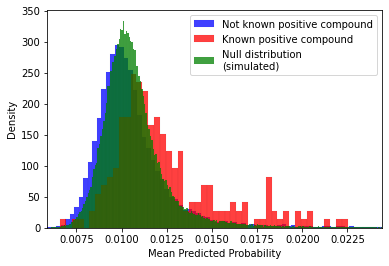

In [ ]:
sns.histplot(y_probas[y == 0], bins=int(np.sqrt(np.sum(y == 0))*10), kde_kws={'gridsize':2000}, stat = 'density', label='Not known positive compound', color='blue')
sns.histplot(y_probas[y == 1], bins=int(np.sqrt(np.sum(y == 1))*10), kde_kws={'gridsize':2000}, stat = 'density', label='Known positive compound', color='red')
sns.histplot(y_probas_means_3, bins=int(np.sqrt(len(y_probas_means_3))*10), kde_kws={'gridsize':2000}, label='Null distribution\n(simulated)', stat = 'density', color='green')
plt.xlabel('Mean Predicted Probability')
plt.xlim([np.min(y_probas), np.percentile(y_probas, 99)])
plt.legend()
plt.savefig('mean-prediction-distribution.svg')
figure_header('Figure', 'Distribution of mean cross-validation predictions ({})'.format(make_clickable('mean-prediction-distribution.svg')))
plt.show()
figure_legend('Figure', 'Distribution of mean cross-validation predictions ({})'.format(make_clickable('mean-prediction-distribution.svg')),
              'Distribution of mean cross-validation predictions for all {number_of_compounds} compounds, \
               including both those with known positive labels and other small molecules.\
                The null distribution was simulated by drawing independent samples of predictions with replacement from the distribution of all predictions.'.format(number_of_compounds=X.shape[0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



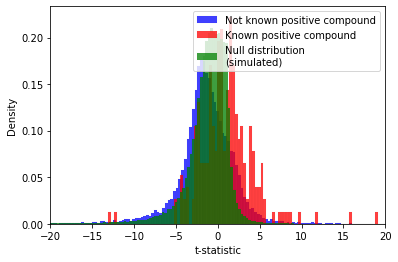

In [ ]:
sns.histplot(t_stats[y == 0], bins=int(np.sqrt(np.sum(y == 0))*10), kde_kws={'gridsize':2000}, stat = 'density', label='Not known positive compound', color = 'blue')
sns.histplot(t_stats[y == 1], bins=int(np.sqrt(np.sum(y == 1))*10), kde_kws={'gridsize':2000}, stat = 'density', label='Known positive compound', color = 'red')
sns.histplot(y_probas_ts_3, bins=int(np.sqrt(len(y_probas_ts_3))*10), kde_kws={'gridsize':2000}, stat = 'density', label='Null distribution\n(simulated)', color = 'green')
plt.xlabel('t-statistic')
plt.xlim([-20,20])
plt.legend()
plt.savefig('t-statistic-distribution.svg')
figure_header('Figure', 'Distribution of t-statistics ({})'.format(make_clickable('t-statistic-distribution.svg')))
plt.show()
figure_legend('Figure', 'Distribution of t-statistics ({})'.format(make_clickable('t-statistic-distribution.svg')),
              'Distributions of t-statistics for all {number_of_compounds} compounds, \
               including both those with known positive labels and other small molecules. \
               The null distribution was simulated by drawing independent samples of predictions with replacement from the distribution of all predictions.'.format(number_of_compounds=X.shape[0]))

Overlaying the predictions on a visualization of the input space allows us to examine the predictions and may indicate groups of highly predicted compounds.

In [ ]:
# Add attributes for plotting to Dataframe
X_reduced_df['Predicted Probability'] = y_probas
X_reduced_df['log10(pred)'] = np.log10(y_probas + 1e-10)
X_reduced_df['p-value'] = p_vals_t_sim
X_reduced_df['log10(p-value)'] = np.log10(X_reduced_df['p-value'])
X_reduced_df['Standard Deviation'] = y_probas_std
X_reduced_df['Cross-validation fold'] = folds_cv
X_reduced_df['marker size'] = 2*np.minimum(2-np.log10(X_reduced_df['p-value']), 5)
X_reduced_df['text'] = ['<br>'.join(['Drug Name: ' + str(name),
                                     'InChI Key: ' + str(inchi),
                                     'Predicted Probability: {:.1e}'.format(p),
                                     'Standard Deviation: {:.1e}'.format(s),
                                     'p-value: {:.1e}'.format(p_val),
                                     'Label: ' + str(label),
                                     'Cross-validation fold: ' + str(fold)])
                  for name, inchi, p, s, p_val, label, fold in zip(X_reduced_df['Drug Name'],
                                                         X_reduced_df['InChI Key'],
                                                         X_reduced_df['Predicted Probability'],
                                                         X_reduced_df['Standard Deviation'],
                                                         X_reduced_df['p-value'],
                                                         X_reduced_df['Label'],
                                                         X_reduced_df['Cross-validation fold'])]
X_reduced_df.to_csv('X_reduced_df.csv')
# Helper function for formatting Plotly colorbar
def colorbar_param(values_log10, **kwargs):
    min_val = np.floor(np.min(values_log10))
    max_val = np.ceil(np.max(values_log10))
    ticks1 = 10**np.arange(min_val, max_val+1)
    ticks2 = 3*10**np.arange(min_val, max_val)
    ticktext = sorted(np.concatenate([ticks1, ticks2]))
    tickvals = list(np.log10(ticktext))
    ticktext = ['{:.0e}'.format(text) for text in ticktext]
    return dict(ticktext=ticktext, tickvals=tickvals, **kwargs)
fig = go.Figure()
for label in sorted(set(X_reduced_df['Label'])):
    X_plot = X_reduced_df[X_reduced_df['Label'] == label].sort_values(['Predicted Probability'])
    fig.add_trace(go.Scatter(mode='markers',
                               x=X_plot['Component 1'], y=X_plot['Component 2'],
                               text=X_plot['text'],
                               name=label,
                               marker=dict(
                                   color=X_plot['log10(pred)'],
                                   cmin=np.percentile(X_reduced_df['log10(pred)'], 50),
                                   cmax=np.max(X_reduced_df['log10(pred)']),
                                   size=X_plot['marker size'],
                                   colorbar=colorbar_param(X_plot['log10(pred)'], title='Predicted Probability'),
                                   symbol=X_plot['marker symbol'],
                                   line_width=1,
                                   colorscale='plasma'
                               )))
fig.update_layout(height=600, width=800,
                  xaxis_title='Component 1',
                  yaxis_title='Component 2',
                  title_text='Predicted Probabilities (UMAP)',
                  #legend_title_text='Target Label',
                  legend=dict(
                      yanchor="top",
                      y=0.98,
                      xanchor="left",
                      x=0.02
                  ),
                  template='simple_white')
figure_header('Figure', 'UMAP dimensionality reduction of the input feature space overlayed with predictions')
fig.show(renderer='colab')
figure_legend('Figure', 'UMAP dimensionality reduction of the input feature space overlayed with predictions',
              f'Each point represents one of {X.shape[0]} compounds, with {X.shape[1]} features per compound, \
              taken from the following datasets: {", ".join(sepl1000_phenotypic_datasets + sepl1000_structural_datasets + attribute_datasets)}. \
              Compounds with known positive labels are marked by X\'s. The color and size of each point correspond to the mean predicted \
              probability and its signficance (estimated from the simulated t-statistic null distribution), respectively.')

Full tables of top-predicted compounds with and without known positive labels are shown below.

In [ ]:
# Obtain prediction results
results = pd.DataFrame(np.array([
    querysepl1000fwd.get_drug_names(X.index),
    Drugmonizome.get_drug_names(X.index),
    folds_cv,
    y,
    y_probas,
    y_probas_std,
    t_stats,
    p_vals,
    p_vals_t,
    p_vals_t_sim,
], dtype='object').T, columns=[
    'Name (L1000FWD)',
    'Name (Drugmonizome)',
    'Cross-validation fold',
    'Known',
    'Prediction Probability',
    'Prediction Probability Std. Dev.',
    't statistic',
    'p value (simulated mean distribution)',
    'p value (one sample t test)',
    'p value (simulated t distribution)',
], index=X.index).astype({'Known': 'bool',
                          'Prediction Probability': 'float64',
                          'Prediction Probability Std. Dev.': 'float64',
                          't statistic': 'float64',
                          'p value (simulated mean distribution)': 'float64',
                          'p value (one sample t test)': 'float64',
                          'p value (simulated t distribution)': 'float64',})
results.to_csv('drug_cv_predictions.csv')

In [ ]:
# Rank predictions
figure_header('Table', 'Top-predicted compounds ({})'.format(make_clickable('drug_cv_predictions.csv')))
show(results.reset_index(), maxBytes=0, order=[[ 5, "desc" ]], columnDefs=[{'width': '120px', 'targets': [0, 1]}])
figure_legend('Table', 'Top-predicted compounds ({})'.format(make_clickable('drug_cv_predictions.csv')),
              f'All {X.shape[0]} compounds ranked by cross-validation prediction probability. \
                Search \'true\' or \'false\' to filter compounds with known positive labels or not, respectively. \
                The table can also be sorted by other columns by selecting the column name in the header.')

## Examine feature importances

The relative contribution of each input feature to the final model predictions can be estimated for recursive feature selection and for a variety of tree-based models. Note that this analysis is not available if a dimensionality reduction algorithm is used.

In [ ]:
all_feature_importances = []
for model in models:
    for calibrated_clf in model.calibrated_classifiers_:
        pipeline = calibrated_clf.base_estimator
        feature_importances = pipeline['clf'].feature_importances_
        all_feature_importances.append(feature_importances)

In [ ]:
dataset_sizes_filtered = list(set(list(filter(lambda x: x[0] in attribute_datasets, dataset_sizes))))
df_feat_imp = pd.DataFrame({'Feature': X.columns,
                            'Dataset': reduce(lambda a,b: a+b, ([dataset]*size for dataset, size in dataset_sizes_filtered)),
                            'Importance Mean': np.mean(all_feature_importances, axis=0),
                            'Importance Std. Dev.': np.std(all_feature_importances, axis=0),
                            })
df_feat_imp = df_feat_imp.set_index('Feature').sort_values('Importance Mean', ascending=False)
figure_header('Table', 'Input features ranked by relative importance ({})'.format(make_clickable('feature_importance.csv')))
show(df_feat_imp.reset_index(), maxBytes=0, order=[[ 2, "desc"]])
figure_legend('Table', 'Input features ranked by relative importance ({})'.format(make_clickable('feature_importance.csv')),
              f'All {X.shape[1]} input features are ranked by their relative importance. \
                Tree-based models can be used to calculate impurity-based feature importances (Importance Mean and Std. Dev.). \
                Search a dataset name to filter features from a given dataset. \
                The table can also be sorted by other columns by selecting the column name in the header.')
df_feat_imp.to_csv('feature_importance.csv')

ValueError: ignored

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
df_feat_imp = df_feat_imp.sort_values('Importance Mean', ascending=False)
for dataset in set(df_feat_imp.Dataset):
    importance_scores = df_feat_imp.loc[df_feat_imp.Dataset == dataset]['Importance Mean'].values
    importance_scores_std = df_feat_imp.loc[df_feat_imp.Dataset == dataset]['Importance Std. Dev.'].values
    lower = importance_scores - importance_scores_std
    upper = importance_scores + importance_scores_std
    axs[0][0].plot(importance_scores, label=dataset)
    axs[0][0].fill_between(np.arange(len(importance_scores)), lower, upper, alpha=.2)
    axs[0][1].plot(np.linspace(0, 1, len(importance_scores)), importance_scores, label=dataset)
    axs[0][1].fill_between(np.linspace(0, 1, len(importance_scores)), lower, upper, alpha=.2)
    importance_scores = np.cumsum(df_feat_imp.loc[df_feat_imp.Dataset == dataset]['Importance Mean'].values)
    axs[1][0].plot(importance_scores, label=dataset)
    axs[1][1].plot(np.linspace(0, 1, len(importance_scores)), importance_scores, label=dataset)
for i in [0, 1]:
    axs[0][i].legend()
    axs[0][i].set_title('Distribution of feature scores from model')
    axs[1][i].set_title('Cumulative distribution of feature scores from model')
    axs[i][0].set_xlabel('Ranked features (absolute count)')
    axs[i][1].set_xlabel('Ranked features (relative count)')
    axs[0][i].set_ylabel('Average feature importance\n(higher score is more important)')
    axs[1][i].set_ylabel('Cumulative sum of feature importance')
    axs[i][0].set_xlim([0,512])
plt.tight_layout()
plt.savefig('feature_importance.svg')
figure_header('Figure', 'Distribution of feature scores from model ({})'.format(make_clickable('feature_importance.svg')))
plt.show()
figure_legend('Figure', 'Distribution of feature scores from model ({})'.format(make_clickable('feature_importance.svg')),
              'The distribution of impurity-based feature importances for each dataset. \
               Features with higher scores have greater relative contribution to the overall tree-based model.')